# Assignment Data Engineer Riku Brandt

### Data
Data can be downloaded from [HRI](https://hri.fi/data/en_GB/dataset/matkustaja-alusten-aikataulu-liikennointi-ja-sijaintitietoja-helsingin-ja-tallinnan-valilla)

| id | updated | ship | imo | lat | long | sog | cog | hdg | depPort | etdSchedule | etd | atd | arrPort | etaSchedule | eta | ata |
| - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - |

In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("finestapi_tracking_db.csv", index_col="id")


# 1.
#### Cleaning

In [362]:
df.dropna(inplace=True)

df["ship"] = df["ship"].str.capitalize()

# Define which company owns the boat.
tallink_ships = ["Megastar", "Star", "Europa"]
df["company"] = np.where(df["ship"].isin(tallink_ships), "Tallink", "Eckerö-Line")


date_columns = { "updated" : "%d/%m/%Y %H:%M", 
                "etdSchedule": "%d/%m/%Y %H:%M",
                  "etd": "%d/%m/%Y %H:%M", 
                  "atd": "%Y-%m-%d %H:%M:%S", 
                  "etaSchedule": "%d/%m/%Y %H:%M",
                    "eta": "%d/%m/%Y %H:%M", 
                    "ata": "%Y-%m-%d %H:%M:%S" }

# Apply the appropriate format to each column
for column, date_format in date_columns.items():
    df[column] = pd.to_datetime(df[column], format=date_format)



# 2.
### List of available ferry names in the dataset.

In [363]:
#ferry_names = df["ship"].str.lower().unique()
ferry_names_df = pd.DataFrame(df["ship"].unique(), columns=["Ferry names"])
ferry_names_df


,Ferry names
0,Megastar
1,Star
2,Europa
3,Finlandia


### Ferry with the highest number of trips each month.

In [364]:
# Create a new column "month" that contains just the year and month
# Ship is considered on the month that it actually departures
df["month"] = df["atd"].dt.to_period("M")

# Count the number of trips (rows) for each ship each month
trips_per_month = df.groupby(["ship", "month"]).size()

# For each month, find the ship with the highest number of trips
top_ferry_per_month = trips_per_month.groupby("month").idxmax()
top_ferry_per_month_df = pd.DataFrame(top_ferry_per_month, columns=["Most trips"])
top_ferry_per_month_df

,Most trips
month,
2018-04,"(Star, 2018-04)"
2018-05,"(Megastar, 2018-05)"
2018-06,"(Megastar, 2018-06)"
2018-07,"(Megastar, 2018-07)"
2018-08,"(Megastar, 2018-08)"
2018-09,"(Megastar, 2018-09)"
2018-10,"(Finlandia, 2018-10)"
2018-11,"(Finlandia, 2018-11)"
2018-12,"(Finlandia, 2018-12)"


#### Ferry that adheres the most to the departure time.

In [366]:

df["departure_diff"] = (df["atd"] - df["etdSchedule"]).dt.total_seconds() / 60

departure_adherence = df.groupby("ship")["departure_diff"].apply(lambda x: np.mean(np.abs(x)))

best_departure_adherence = departure_adherence.idxmin()
best_departure_adherence


'Finlandia'

#### Ferry that adheres the most to the arrival time.

In [367]:
df["arrival_diff"] = (df["ata"] - df["etaSchedule"]).dt.total_seconds() / 60

arrival_adherence = df.groupby("ship")["arrival_diff"].apply(lambda x: np.mean(np.abs(x)))
best_arrival_adherence = arrival_adherence.idxmin()
best_arrival_adherence

'Star'

# 3.
#### Total number of trips for each company

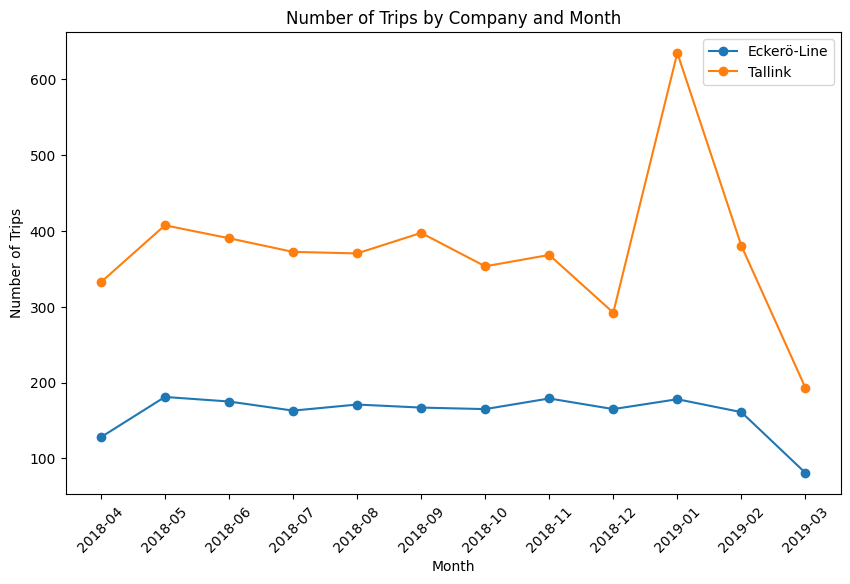

In [368]:
company_month_trips = df.groupby(["company", "month"]).size().reset_index(name="trip_count")
plt.figure(figsize=(10, 6))
for company in company_month_trips["company"].unique():
    data = company_month_trips[company_month_trips["company"] == company]
    plt.plot(data["month"].astype(str), data["trip_count"], marker="o", label=company)

plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.title("Number of Trips by Company and Month")
plt.legend()
plt.xticks(rotation=45)
plt.show()

#### Difference between estimated departure and actual departure time


<Figure size 1000x600 with 0 Axes>

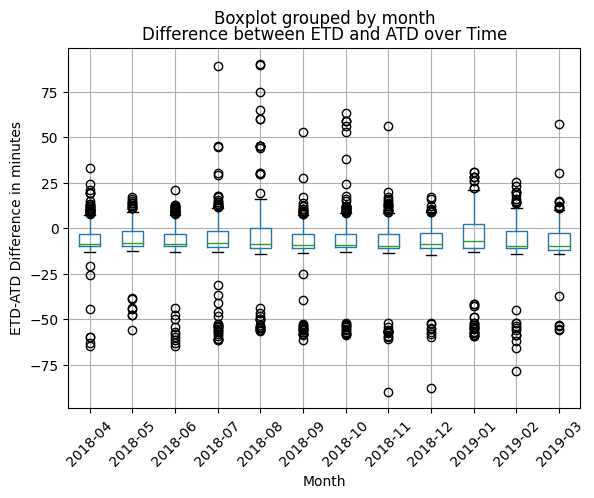

In [369]:
# Create a box plot to visualize the difference over time

df["dd_z_score"] = stats.zscore(df["departure_diff"])
plt.figure(figsize=(10, 6))

# Filter out data that has z_score higher than 3.
df[df["dd_z_score"].abs() <= 3].boxplot(column="departure_diff", by="month")

plt.xlabel("Month")
plt.ylabel("ETD-ATD Difference in minutes")
plt.title("Difference between ETD and ATD over Time")
plt.xticks(rotation=45)
plt.show()

#### Difference between ETA and ATA

<Figure size 1000x600 with 0 Axes>

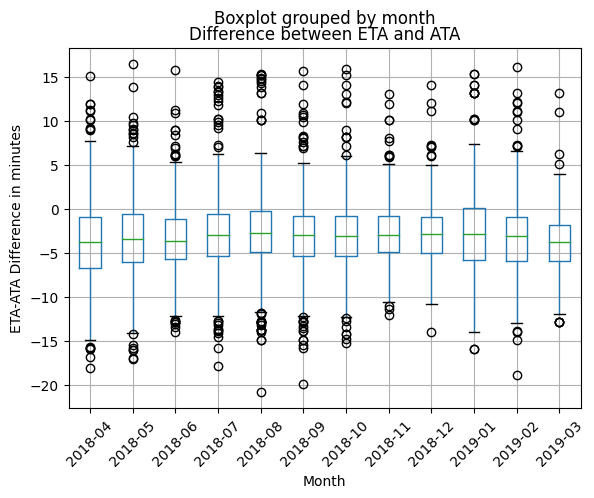

In [370]:
df["ad_z_score"] = stats.zscore(df["arrival_diff"])

plt.figure(figsize=(10, 6))
df[df["ad_z_score"].abs() <= 3].boxplot(column="arrival_diff", by="month")
plt.xlabel("Month")
plt.ylabel("ETA-ATA Difference in minutes")
plt.title("Difference between ETA and ATA")
plt.xticks(rotation=45)
plt.show()

#### Scatter plot between speed over ground (SOG) and trip duration.

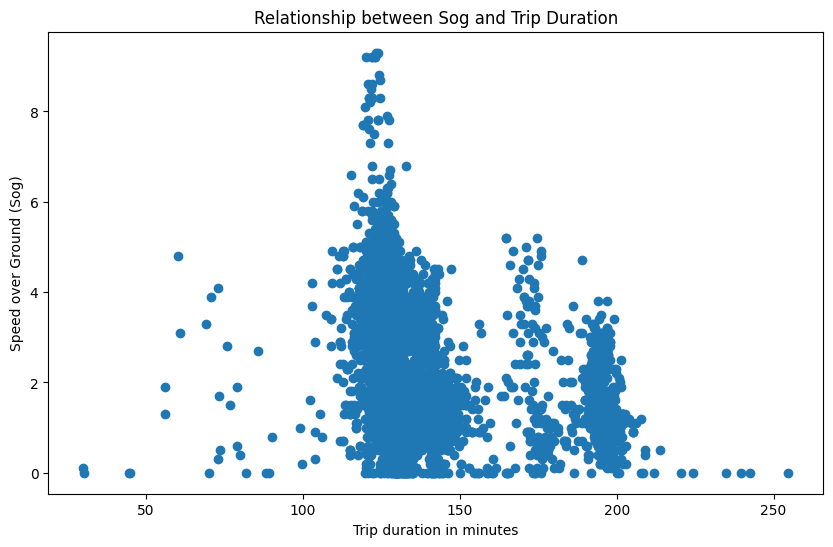

In [371]:
df["trip_duration"] = (df["ata"] - df["atd"]).dt.total_seconds() / 60

# Filtering of outliers
trip_duration_zscore = stats.zscore(df["trip_duration"])
sog_zscore = stats.zscore(df["sog"])

filter_condition = (np.abs(sog_zscore) <= 3) & (np.abs(trip_duration_zscore) <= 3)


plt.figure(figsize=(10, 6))
plt.scatter(df["trip_duration"][filter_condition], df["sog"][filter_condition])

plt.xlabel("Trip duration in minutes")
plt.ylabel("Speed over Ground (Sog)")
plt.title("Relationship between Sog and Trip Duration")
plt.show()

#### Scatter plot for ATD-ETD and ATA-ETA

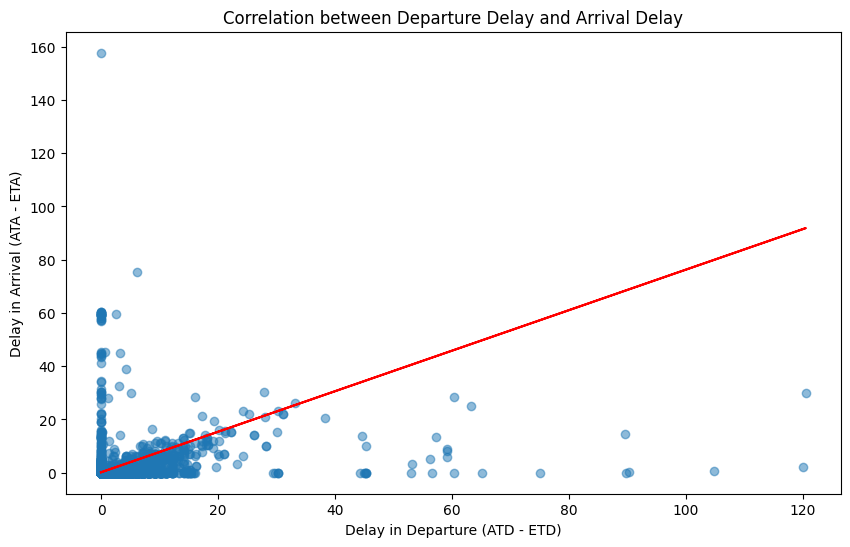

In [372]:
df["departure_delay"] = df["departure_diff"].clip(lower=0)
df["arrival_delay"] = df["arrival_diff"].clip(lower=0)


plt.figure(figsize=(10, 6))
plt.scatter(df["departure_delay"], df["arrival_delay"], alpha=0.5)

b, m = np.polyfit(df["departure_delay"], df["arrival_delay"], 1)

plt.plot(df["departure_delay"], m*df["departure_delay"] + b, color="red")

plt.xlabel("Delay in Departure (ATD - ETD)")
plt.ylabel("Delay in Arrival (ATA - ETA)")
plt.title("Correlation between Departure Delay and Arrival Delay")
plt.show()

The scatter plot with a best-fit line shows that there is a general trend where late departures tend to be associated with late arrivals. Although the line does not perfectly follow a diagonal, it suggests that there is a possibility for the trip to partially catch up with the delay in departure. In other words, even if the departure is delayed, the trip duration may help reduce the overall delay in arrival to some extent.







## Bonus
Inspect what weekdays have the highest delays in departure times.


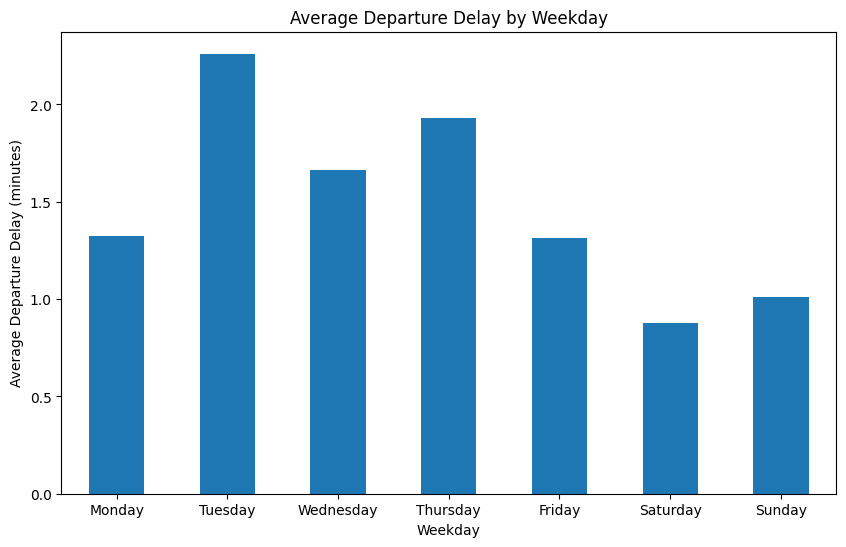

In [373]:
desired_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df["departure_delay"] = df["departure_diff"].clip(lower=0)

df["departure_weekday"] = df["atd"].dt.day_name()
departure_delays_by_weekday = df.groupby("departure_weekday")["departure_delay"].mean()
departure_delays_by_weekday = departure_delays_by_weekday.reindex(desired_order)

plt.figure(figsize=(10, 6))
departure_delays_by_weekday.plot(kind="bar")
plt.xlabel("Weekday")
plt.ylabel("Average Departure Delay (minutes)")
plt.title("Average Departure Delay by Weekday")
plt.xticks(rotation=0)
plt.show()